# Quantum Simulation of Hamiltonians using qDRIFT

**Please execute the cell below before proceeding:**

In [1]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from scipy import linalg as sla
import itertools as iter
import sys
import random as rand
from scipy.spatial import distance
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper, LogarithmicMapper
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, QEOM
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, AncillaRegister, transpile
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity, Statevector, Operator, Pauli, SparsePauliOp
from qiskit import Aer
from qiskit.primitives import Estimator
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal, PauliEvolutionGate
from qiskit.algorithms import TimeEvolutionProblem, RealTimeEvolver, RealEvolver, SciPyRealEvolver, VarQRTE
from qiskit.algorithms.time_evolvers import TrotterQRTE
from qiskit.circuit import Parameter, ControlledGate, Gate
from qiskit.extensions import UnitaryGate
from qiskit.converters import circuit_to_gate
from qiskit.synthesis import SuzukiTrotter, LieTrotter, MatrixExponential
from qiskit.quantum_info import Choi, diamond_norm

## Contents:

1. [Introduction](#introduction)
2. [Theory](#theory-of-qdrift-algorithm)
3. [Electronic Hamiltonian](#electronic-hamiltonian)
4. [Heisenberg Hamiltonian](#heisenberg-model-lattice-based)
5. [Ising Hamiltonian](#ising-model-lattice-based)
6. [Discussion](#discussion)
7. [References](#citations)

## Introduction:

Simulation of a physical system, represented by a Hamiltonian, is the primary purpose of quantum simulation, particularly as it relates to quantum dynamics. Such a practice can be used to determine various characteristics of physical systems using an approximation, facilitated via a simulation algorithm, of the often-complicated dynamics of said system. One such algorithm is the quantum stochastic drift protocol, known simply as qDRIFT [2]. 

The qDRIFT algorithm is a “splitting” method protocol that constructs a random circuit composed of unitary evolution operators selected from a normalized probability distribution [3]. This “splitting” procedure is also found within product formulas derived from Lie-Suzuki-Trotter approximation algorithms, with Hamiltonian summand exponentiation into unitary operators being an integral component of both qDRIFT and product formulas [3, 7]. 

Unlike product formulas, qDRIFT error bounds are not dependent upon the number of summands within the analyzed Hamiltonian, and the time evolution “stochastically drifts” toward the ideal evolution via encoded biases in the repetition and placement of selected unitary summand gates [4].

This notebook will feature comparisons between ideal and qDRIFT-based time evolutions via the simulation of Electronic, Heisenberg, and Ising Hamiltonians. Prior to these comparisons, an explanation concerning the structure, procedure, and secondary characteristics of the qDRIFT are necessary.

## Theory of qDRIFT Algorithm:

Given that the qDRIFT protocol uses a randomized splitting operation to construct evolution circuits, it is best to begin with this chief principle [4]. Hamiltonians employed within this stochastic algorithm are composed of weighted summands that are exponentiated as dictated by a normalized probability distribution. This is achieved by computing the summation of all weights, denoted as ${λ}$, normalizing the ${j}$-th weight of the Hamiltonian by ${λ}$, and referencing this ${j}$-th probability when randomly selecting exponentiated summands to place on the respective circuit, thus simulating time evolution. The Hamiltonian used in this process is:

$$ \large H = \sum_{j=1}^{L}{h_j H_j} $$

where ${L}$ is the summand count of the Hamiltonian, and ${h_j}$ is the weight associated with the ${j}$-th summand ${H_j}$ [3]. 

Accompanied by the constructed distribution, the operator summands of the Hamiltonian are appended to a generalized “drift” operator that is repeated ${r}$ times to approximate the ideal unitary operator ${U}$. This approximation, relative to a specified accuracy, is best portrayed at large repetitions counts. The “drift operator” used in this approximation is:

$$ \large V_j = \prod_{j=1}^{r}{e^{i t h_j H_j / r}}$$

where ${t}$ is the termination time/evolution time of the operator, and ${r}$ is the repetition count of the “drift operator” [3]. 

The stochastic nature of this algorithm results in gate complexity and Trotter error bounds that are, as explained further within [3], independent of the summand count of the base Hamiltonian. As such, this independence results in a better upper bound for Trotter error in comparison to conventional Lie-Suzuki-Trotter formulas. This is showcased within the inequality:

$$ \epsilon = N \delta \underset{ \large \sim}{<} \frac{2 \lambda^2 t^2}{N}$$

where ${ε}$ is the error of the algorithm, ${N}$ is the total gate count of the constructed qDRIFT circuit, and ${δ}$ is the approximation error of a single “drift operator”, ${V_j}$ [4]. The total gate count for the algorithm can be easily obtained by simple algebraic operations employing the expression above: ${N = \frac{\delta}{\epsilon} }$. However, this upper bound has been shown to be worse than higher-level Trotter formulas; this relationship is further demonstrated at threshold times wherein product formulas perform better than the qDRIFT protocol at large ${t}$ [4, 5].

The pseudocode of the qDRIFT algorithm [3] is detailed below:

**Input:** A list of Hamiltonian terms ${H = \sum_{j}{h_j H_j}}$, a classical oracle function ${S A M P L E ()}$ that returns a value ${j}$ from the probability distribution ${p_j = h_j / (\sum_{j}{h_j})}$ and a target precision ${\epsilon}$.

**Output:** An ordered list ${V_{list}}$ of unitary gates of the form ${e^{i \tau H_j}}$

1. ${\lambda \leftarrow \sum_{j}{h_j}}$

2. ${N \leftarrow \lceil 2 \lambda^2 t^2 / \epsilon \rceil}$

3. ${i \leftarrow 0}$

4. ${V_{list} = \{}\}$ (set gate list empty)

5. While ${i < N }$

     1. ${i \leftarrow i + 1}$

     2. ${j \leftarrow SAMPLE()}$

     3. Append ${e^{i \lambda H_j / N}}$ to ordered list ${V_{list}}$

6. Return ${V_{list}}$

We are now sufficiently prepared to view several examples that illustrate the above concepts via code. These examples will span the Electronic, Heisenberg, and Ising Hamiltonians; the Electronic Hamiltonian will be our first system analyzed.  

But first, run the following cells to set up the necessary methods used in this notebook:

In [6]:
# Define a function "gen_essentials" to generate all stochastic variables/sets necessary to construct the cumulative unitary operator for large repetitions:

def gen_essentials(hamiltonian):

    selection = range(1, len(hamiltonian) + 2)

    weights_list = rand.sample(selection, len(hamiltonian))

    lamb = sum(weights_list)

    prob_dist = [x / lamb for x in weights_list]

    qDRIFT_triple = (lamb, prob_dist, weights_list)

    return (qDRIFT_triple)

In [7]:
# Define a function to randomly pick a unitary operator:

def pick(summand_list, prob_dist):

    bucket = rand.choices(summand_list, weights=prob_dist, cum_weights=None, k=1)

    return(bucket)

In [8]:
# Generate the evolved state vectors and cache their associated coefficients:

def state_generation(hamiltonian, time_range, initial_state):

    state_coefficients = np.empty(shape=(2**(hamiltonian.num_qubits), len(time_range)), dtype=tuple)

    exact_energies = list()

    exact_initial = initial_state.to_instruction()

    exact_initial = Statevector.from_instruction(exact_initial)

    m_exp = MatrixExponential()

    for k in range(len(time_range)):

        exact_unitary_Exp = PauliEvolutionGate(hamiltonian, time=time_range[k], synthesis= m_exp)

        evolved_state_Exp = exact_initial.evolve(exact_unitary_Exp)

        exact_energies.append(evolved_state_Exp.expectation_value(hamiltonian))

        for j in range(len(evolved_state_Exp.data)):

            coefficients_re = np.real(evolved_state_Exp.data[j])
            coefficients_im = np.imag(evolved_state_Exp.data[j])

            coefficients_pair = (coefficients_re, coefficients_im)
            
            state_coefficients[j][k] = coefficients_pair

    pair = (state_coefficients, exact_energies)

    return(pair)

In [9]:
# Define a function to identify states that have some excitation/probability of being measured:

def identify_states(state_list, hamiltonian, time_range):

   #print("Arrived at identify_states function!")

    meaningful_states = list()

    bool_states = [False] * 2**(hamiltonian.num_qubits)

    for i in range(len(time_range)):

        for j in range(2**(hamiltonian.num_qubits)):

            pair = state_list[j][i]

            if (pair[0] != 0 and pair[1] != 0j):
                bool_states[j] = True
                
    for k in range(len(bool_states)):
        if (bool_states[k] == True):
            meaningful_states.append(k)

    return(meaningful_states)

In [10]:
# Define a function to compose the qDRIFT circuit via the appropriate protocol:

def qDRIFT_protocol(hamiltonian, initial_state, time_range, accuracy, reps):
    
    qDRIFT_energies = list()
    estimator = Estimator()
    exp_summand = list()
    evo_time = Parameter('t')

    qDRIFT_coefficients = np.empty(shape=(2**(hamiltonian.num_qubits), len(time_range)), dtype=tuple)

    # Obtain the essential variables (probability distribution and cumulative weight of summand coefficients):

    qDRIFT_pair = gen_essentials(hamiltonian)

    # Obtain the selection count necessary to construct the equivalent unitary list:

    N = np.ceil((2 * qDRIFT_pair[0]**2 * time_range[-1]**2) / (accuracy))

    # Partition each qubit_h2_Ham list object into separate list of exponentiated summands:

    for i in range(0, len(hamiltonian)):
        exp_summand.append(PauliEvolutionGate(hamiltonian[i], time=(qDRIFT_pair[0] *evo_time) / reps))

    # Perform Selection algorithm to construct the V_list operator:

    V_list = list()

    #for i in range(0, int(N)):
    for i in range(0, reps):
        V_list.append(pick(exp_summand, qDRIFT_pair[1]))

    # Append V_list gates to template circuit:

    Rand_circuit = QuantumCircuit(initial_state.width())

    for i in range(len(V_list)):
        Rand_circuit.append(V_list[i][0], range(initial_state.width()))

    #for j in range(reps):
    #    Rand_circuit.compose(Rand_circuit, range(Rand_circuit.width()))

    qDRIFT_circ = initial_state.compose(Rand_circuit, range(initial_state.width()))

    # Prepare an estimator to measure expectation value of Hamiltonian:

    for k in range(len(time_range)):

        result = estimator.run(qDRIFT_circ, hamiltonian, parameter_values=[time_range[k]]).result()
        
        qDRIFT_energies.append(np.real(result.values))
        
        qDRIFT_circ_copy = qDRIFT_circ.assign_parameters({evo_time: time_range[k]}, inplace = False)

        qDRIFT_op = Operator.from_circuit(qDRIFT_circ_copy)

        qDRIFT_instruct = Operator.to_instruction(qDRIFT_op)

        qDRIFT_vector = Statevector.from_instruction(qDRIFT_instruct)

        for j in range(len(qDRIFT_vector.data)):

            coefficients_re = np.real(qDRIFT_vector.data[j])
            coefficients_im = np.imag(qDRIFT_vector.data[j])

            coefficients_pair = (coefficients_re, coefficients_im)
            
            qDRIFT_coefficients[j][k] = coefficients_pair

    qDRIFT_tuple = (qDRIFT_circ, qDRIFT_energies, qDRIFT_coefficients, qDRIFT_pair)

    return (qDRIFT_tuple)

## Electronic Hamiltonian:

### Dihydrogen Molecule (Molecular Orbital Basis):

The Electronic Hamiltonian represents the internal energies of a molecule following the removal of kinetic energy terms from the Hamiltonian due to Born-Oppenheimer approximation [19]. This Hamiltonian has the nuclear coordinate form:

$$ \large \mathcal{H}_{el} = - \sum_{i}{\frac{\nabla^{2}_{r_i}}{m_e}} - \sum_{I}{\sum_{i}{\frac{Z_I e^2}{\mid R_I - r_i \mid}}} \ + \ \sum_{i}{\sum_{j>i}{\frac{e^2}{\mid r_i - r_j \mid}}} $$

where ${r_i}$ and ${r_j}$ are the coordinates of the ${i}$-th and ${j}$-th electron, respectively, ${m_e}$ is the mass of the electron, ${Z_I}$ is the atomic number of the nucleus ${I}$, ${R_I}$ are the coordinates of the nucleus ${I}$, and ${e}$ is the electron charge [17]. This form will not be relevant to practical applications of product formulas. The second quantized form (Molecular Orbital basis) of the Electronic Hamiltonian is:

$$ \large \hat{H}_{elec} = \sum_{pq}{h_{pq} \hat{a}_{p}^{\dagger} \hat{a}_{q}^{\dagger}} \ + \ \frac{1}{2} \sum_{pqrs}{h_{pqrs} \hat{a}_{p}^{\dagger} \hat{a}_{q}^{\dagger} \hat{a}_{r} \hat{a}_{s}} $$

where ${\hat{a}_{k}^{†}}$ and ${\hat{a}_{k}}$ , with ${k = pq,\ pqrs,\ p,\ q,\ r,\ s}$,  are the creation and annihilation operators of the fermions, and ${h_{pq}}$ and ${h_{pqrs}}$
are the 1-body and 2-body integrals, respectively.  Further information regarding second quantized Electronic Hamiltonians can be found here: [18]. Using the Jordan-Wigner Transformation, we will bring this fermionic Electronic Hamiltonian into the qubit space to manipulate it.

We will begin learning how to implement the qDRIFT protocol using Electronic Hamiltonians via interactive examples. Be sure to read the comments in the code for more notes.


**Please run the cell below prior to attempting to execute further cells in this section.**

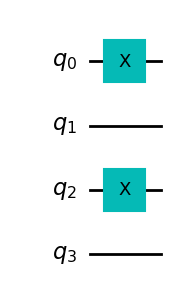

In [11]:
# Prepare a Dihydrogen Molecule within its second_q_op structure:

h2_driver = PySCFDriver(
    atom = "H 0 0 0; H 0 0 0.735",
    basis = "sto3g",
    charge = 0,
    spin = 0,
    unit = DistanceUnit.ANGSTROM,
)

# Create Problem instance for dihydrogen molecule:

diHydro_prob = h2_driver.run()

# Generate the Electronic Hamiltonian for Dihydrogen:

h2_Hamiltonian = diHydro_prob.hamiltonian
coefficients = h2_Hamiltonian.electronic_integrals

# Apply second-quantization transformation to Electronic Hamiltonian:

sq_h2_op = h2_Hamiltonian.second_q_op() # This Second-Quantized Electronic Hamiltonian does NOT contain the nuclei repulsive/attractive terms!

# Set up Jordan-Wigner Mapper/Transformer to bring Second Quantized Hamiltonian into qubit space:

jw_map = JordanWignerMapper()

# Apply mapper to Second Quantized Electronic Hamiltonian:

qubit_h2_Ham = jw_map.map(sq_h2_op)

# Obtain the initial state from which to apply the time evolution of the converted Hamiltonian:

HartreeFock_initial = HartreeFock(diHydro_prob.num_spatial_orbitals, diHydro_prob.num_particles, jw_map,)

# Draw the initial state to evolve:

HartreeFock_initial.draw('mpl')

The cell above produces the initial ground state from which the system will evolve. In the case of the Electronic Hamiltonian, the initial state is called a Hartree-Fock state [3]. Other configurations than the one presented are possible; view the appended reference for further information on Hartree-Fock states.

The cell below holds the Electronic Hamiltonian parameters. Configure these values to produce other Hamiltonian variations. Reference the respective Qiskit documentation page for further information on this model [1].

In [12]:
# Select an appropriate order, accuracy, evolution time, time step size, and Trotter number for the qDRIFT Protocol:

'''These are the general control parameters for the Electronic Hamiltonian. Refer to these (and change) these variables to experiment with various random unitary configurations'''

final_time = 25 # Termination time of real time evolution.
time_step = 0.1 # Time step increment for sampling purposes. Does not affect the Product Formula construction.
epsilon = 1.6 * 10**(-3) # Select a desired chemical accuracy for simulation purposes.
h2_reps = 10

evo_time_range = np.arange(0, final_time, time_step) # Define a time evolution range that will scale to the plotted Hamiltonian evolution.


In [13]:
# Invoke the qDRIFT Protocol:

qDRIFT_result = qDRIFT_protocol(qubit_h2_Ham, HartreeFock_initial, evo_time_range, epsilon, h2_reps)

'''Warning: Given the nature of qDRIFT, accurate approximation leads to large gate complexity! Be careful when drawing!'''

#qDRIFT_result[0].draw()

'Warning: Given the nature of qDRIFT, accurate approximation leads to large gate complexity! Be careful when drawing!'

In [14]:
# Obtain a list of states that are meaningful to plot (i.e., have some probability of being measured):

h2_states = identify_states(qDRIFT_result[2], qubit_h2_Ham, evo_time_range)

print(h2_states)

# Obtain a list of coefficients that correspond to meaningful states: 

h2_coefficients_re_approx = np.zeros(shape=(2**(qubit_h2_Ham.num_qubits), len(evo_time_range)))
h2_coefficients_im_approx = np.zeros(shape=(2**(qubit_h2_Ham.num_qubits), len(evo_time_range)))

for i in range(2**qubit_h2_Ham.num_qubits):

    for j in range(len(evo_time_range)):

        real = qDRIFT_result[2][i][j][0]
        imag = qDRIFT_result[2][i][j][1]

        h2_coefficients_re_approx[i][j] = real 
        h2_coefficients_im_approx[i][j] = imag

[5, 10]


The above list denotes the state numbers (in decimal as opposed to binary) that exhibit some meaningful probablity of being measured when the associated waveform "collapses".

The variable "h2_states" is a 0-indexed list of each of the meaningful states/excitation levels. When attempting to plot the coefficients for each state, change the index (starting from 0) within each instance that "h2_states[any valid index in above list]" appears.

> Example: **h2_coefficients_re_approx[h2_states[1]]** should, if nothing in the above cell has been modified, yield the real and imaginary components of the state coefficient for |1010⟩. 

Try this procedure on all the Hamiltonian types that follow!

#### Electronic Hamiltonian Expectation Value over Time Evolution:

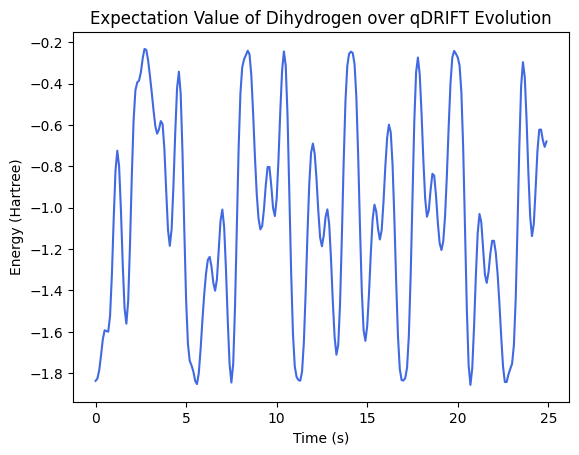

In [15]:
# Graph the energy variation over the specified time interval:

plt.plot(evo_time_range, qDRIFT_result[1], color="royalblue")
plt.xlabel("Time (s)")
plt.ylabel("Energy (Hartree)")
plt.title("Expectation Value of Dihydrogen over qDRIFT Evolution")
plt.savefig('./Plots/qDRIFT/Expectation Values/h2_'+ str(evo_time_range[-1]) + 's_' + str(h2_reps) + 'r.png')

The above diagram showcases the expectation value of the Electronic hamiltonian as the system evolved in time. Given the trotterized nature of each of the randomly selected unitary operators, the expectation value will differ with each instance the qDRIFT algorithm is run.

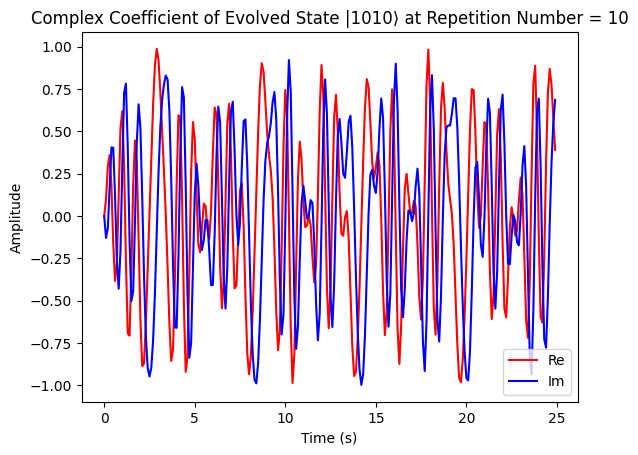

In [16]:
# Plot the evolved state coefficients:

plt.plot(evo_time_range, h2_coefficients_re_approx[h2_states[1]], color = 'r', label = "Re")
plt.plot(evo_time_range, h2_coefficients_im_approx[h2_states[1]], color = 'b', label = "Im")
plt.title('Complex Coefficient of Evolved State |' + format(h2_states[1], '0' + str(qubit_h2_Ham.num_qubits) + 'b') + '⟩ at Repetition Number = ' + str(h2_reps))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc="best")
plt.savefig('./Plots/qDRIFT/States/Coefficient_h2_'+ format(h2_states[1], '0' + str(qubit_h2_Ham.num_qubits) + 'b') + '_' + str(h2_reps) + 'r.png' )


#### Necessary Gate Count for Constant Accuracy:

This widget is employed to calculate the total gate and repetition counts necessary to achieve the specified constant accuracy:

In [17]:
# Calculate the necessary gate count for constant accuracy:

N = np.ceil((2 * qDRIFT_result[3][0]**2 * evo_time_range[-1]**2) / (epsilon))

print("The necessary total gate count for constant accuracy is: " + str(N))

The necessary total gate count for constant accuracy is: 11725164113.0


#### Trotter Error Bound:

This widget is employed to calculate the upper Trotter Error bound given the qDRIFT parameters:

In [18]:
# Calculate the upper bounded Trotter error of the qDRIFT configuration:

'''Warning: Using low repetition counts for the qDRIFT protocol will result in an inexpressibly high Trotter Error (i.e., O(inf)). Be aware!'''

h2_error = (2 * qDRIFT_result[3][0]**2 * final_time**2) / h2_reps

print("The associated upper bound Trotter Error of this qDRIFT configuration is: O(" + str(h2_error) + ")")

The associated upper bound Trotter Error of this qDRIFT configuration is: O(1891125.0)


### Relationship Plots

The plots within this section will highlight some key characteristics that distinguish the qDRIFT algorithm from other Trotterization-based procedures. All subsequent Hamiltonians examined within this notebook will feature respective plots dependent on the input parameters for the corresponding Hamiltonian. 

#### Trotter Error vs. Repetitions

/tmp/ipykernel_6322/3339457815.py:7: RuntimeWarning: overflow encountered in exp
  rep_num_range.append((len(qubit_h2_Ham)**2 * (max(qDRIFT_result[3][2]))**2 * (final_time)**2 * np.exp((max(qDRIFT_result[3][2]) * final_time * len(qubit_h2_Ham))/rep_range[j])) / 2 * rep_range[j])


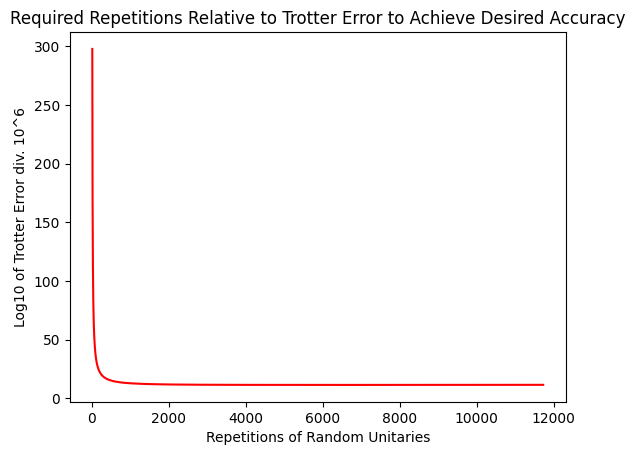

In [19]:
# Plot the relationship between Repetitions and Trotter Error:

rep_range = np.arange(1, N / 10**6, 1) # Range to plot Product Formula order
rep_num_range = list() # List for Trotter Number required per order and qubits.

for j in range(len(rep_range)):
    rep_num_range.append((len(qubit_h2_Ham)**2 * (max(qDRIFT_result[3][2]))**2 * (final_time)**2 * np.exp((max(qDRIFT_result[3][2]) * final_time * len(qubit_h2_Ham))/rep_range[j])) / 2 * rep_range[j])

plt.plot(rep_range, np.log10(rep_num_range), color="red")
plt.xlabel("Repetitions of Random Unitaries")
plt.ylabel("Log10 of Trotter Error div. 10^6")
plt.title("Required Repetitions Relative to Trotter Error to Achieve Desired Accuracy")
plt.savefig('./Plots/qDRIFT/Relationship Diagrams/Error_vs_Reps_h2_' + str(h2_reps) + 'r.png' )

#### Trotter Error vs. Time: 

/tmp/ipykernel_6322/1917590664.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.plot(time_range, np.log10(error_times), color="red")


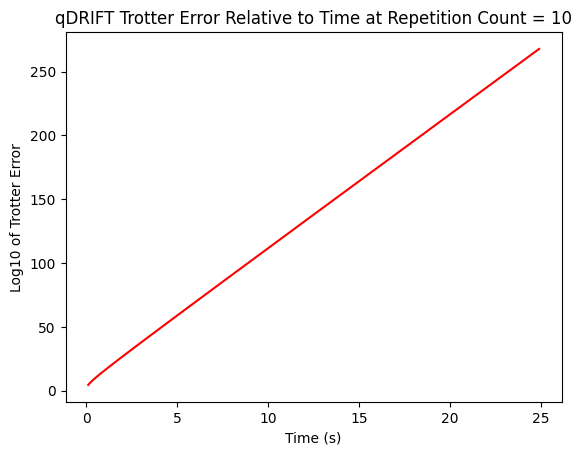

In [20]:
# Plot the relationship between time and Trotter Error given current repetition count:

time_range = np.arange(0, final_time, 0.1) # Range to plot Product Formula order
error_times = list() # List for Trotter Number required per order and qubits.

for j in range(len(time_range)):
    error_times.append((len(qubit_h2_Ham)**2 * (max(qDRIFT_result[3][2]))**2 * (time_range[j])**2 * np.exp((max(qDRIFT_result[3][2]) * time_range[j] * len(qubit_h2_Ham))/h2_reps)) / 2 * h2_reps)

plt.plot(time_range, np.log10(error_times), color="red")
plt.xlabel("Time (s)")
plt.ylabel("Log10 of Trotter Error")
plt.title("qDRIFT Trotter Error Relative to Time at Repetition Count = " + str(h2_reps))
plt.savefig('./Plots/qDRIFT/Relationship Diagrams/Error_vs_Time_h2_' + str(h2_reps) + 'r.png' )

### Via Standard Methods:

This section will visualize the ideal time evolution of the respective Hamiltonian and contrast ideal and approximate evolutions of the state coefficients, including the Euclidean distance between each of the sampled coefficient amplitudes from both the ideal and approximate models. Every subsequent Hamiltonian within this notebook is analyzed in this manner.

**The cell below must be executed prior to plotting the comparison between the approximation and ideal time evolutions found below. This must be done for each modification to the approximation model.**

In [21]:
# Obtain a list of states that are meaningful to plot (i.e., have some probability of being measured):

exact_attri = state_generation(qubit_h2_Ham, evo_time_range, HartreeFock_initial)

h2_states = identify_states(exact_attri[0], qubit_h2_Ham, evo_time_range)

print(h2_states)

# Obtain a list of coefficients that correspond to meaningful states: 

h2_coefficients_re_ex = np.zeros(shape=(2**(qubit_h2_Ham.num_qubits), len(evo_time_range)))
h2_coefficients_im_ex = np.zeros(shape=(2**(qubit_h2_Ham.num_qubits), len(evo_time_range)))

for i in range(2**qubit_h2_Ham.num_qubits):

    for j in range(len(evo_time_range)):

        real = exact_attri[0][i][j][0]
        imag = exact_attri[0][i][j][1]

        h2_coefficients_re_ex[i][j] = real
        h2_coefficients_im_ex[i][j] = imag
        

[5, 10]


Just as is presented in the qDRIFT-approximate model of this Hamiltonian, the above list denotes the state numbers (in decimal as opposed to binary) that exhibit some meaningful probablity of being measured when the associated waveform "collapses". The number of states that genuinely exhibit non-zero probability ampltitudes may differ from those found in the qDRIFT model.

#### Ideal Expectation Value:

/home/ssr/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


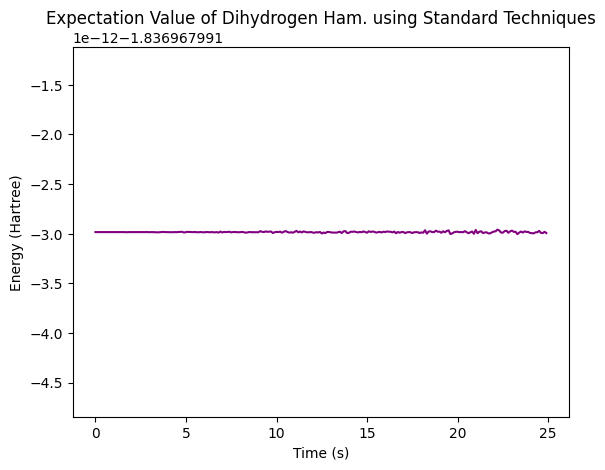

In [22]:
# Plot the expectation value of the exact time evolution:

plt.plot(evo_time_range, exact_attri[1], color='purple')
plt.xlabel("Time (s)")
plt.ylabel("Energy (Hartree)")
plt.title("Expectation Value of Dihydrogen Ham. using Standard Techniques")
plt.savefig("./Plots/qDRIFT/Expectation Values/Expectation_Value_Standard_h2.png")

#### Ideal State Coefficient Evolution:

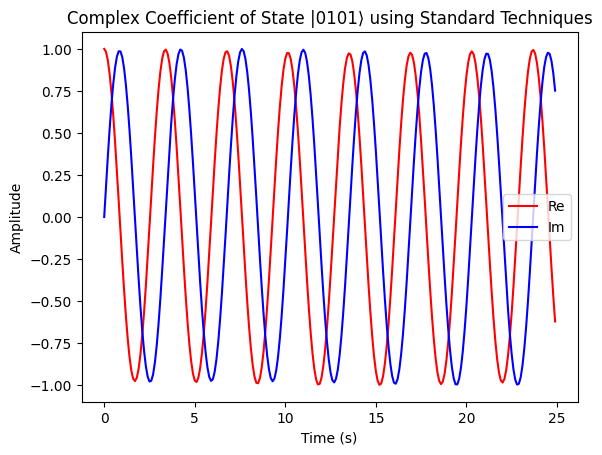

In [23]:
# Plot the Real and Imaginary components of the two resultant states in the evolved statevector:

plt.plot(evo_time_range, h2_coefficients_re_ex[h2_states[0]], color='r', label= "Re")
plt.plot(evo_time_range, h2_coefficients_im_ex[h2_states[0]], color='b', label= "Im")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc="best")
plt.title("Complex Coefficient of State |" + format(h2_states[0], '0' + str(qubit_h2_Ham.num_qubits) + 'b') + "⟩ using Standard Techniques")
plt.savefig("./Plots/qDRIFT/States/Complex_Coefficients_of_State_" + format(h2_states[0], '0' + str(qubit_h2_Ham.num_qubits) + 'b') + "_Standard_" + str(final_time) + "s_" + str(h2_reps) + "r_h2.png")

#### Comparison between Approximate and Ideal Evolutions:

We will now compare the two models of time evolution, based upon the chosen qDRIFT configuration, and obtain the Euclidean distance, which denotes the deviation from each ideal state amplitude.

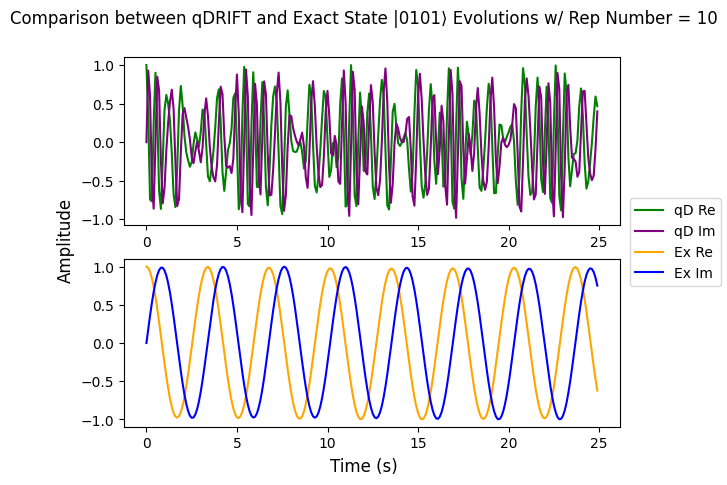

In [24]:
fig, axs = plt.subplots(2)
fig.suptitle("Comparison between qDRIFT and Exact State |" + format(h2_states[0], '0' + str(qubit_h2_Ham.num_qubits) + 'b') + "⟩ Evolutions w/ Rep Number = " + str(h2_reps))
axs[0].plot(evo_time_range, h2_coefficients_re_approx[h2_states[0]], color = 'g', label = "qD Re")
axs[0].plot(evo_time_range, h2_coefficients_im_approx[h2_states[0]], color = 'purple', label = "qD Im")
axs[1].plot(evo_time_range, h2_coefficients_re_ex[h2_states[0]], color='orange', label= "Ex Re")
axs[1].plot(evo_time_range, h2_coefficients_im_ex[h2_states[0]], color='b', label= "Ex Im")
fig.supxlabel("Time (s)")
fig.supylabel("Amplitude")
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lin, []) for lin in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.865,0.41))
plt.savefig("./Plots/qDRIFT/States/Coefficient_Comparison_of_State_" + format(h2_states[0], '0' + str(qubit_h2_Ham.num_qubits) + 'b') + "_" + str(final_time) + "s_" + str(h2_reps) + "r_h2.png")

In [25]:
# Calculate the Euclidean Distance between the two state coefficient plots:

for k in range(len(h2_states)):
    h2_re_distance = distance.euclidean(h2_coefficients_re_approx[h2_states[k]], h2_coefficients_re_ex[h2_states[k]])
    h2_im_distance = distance.euclidean(h2_coefficients_im_approx[h2_states[k]], h2_coefficients_im_ex[h2_states[k]])

    print("The Real Euclidean distance/error of state |" + format(h2_states[k], '0' + str(qubit_h2_Ham.num_qubits) + 'b') + "⟩ is: " + str(h2_re_distance))
    print("The Imaginary Euclidean distance/error of state |" + format(h2_states[k], '0' + str(qubit_h2_Ham.num_qubits) + 'b') + "⟩ is: " + str(h2_im_distance))

The Real Euclidean distance/error of state |0101⟩ is: 13.582966061933346
The Imaginary Euclidean distance/error of state |0101⟩ is: 13.655879063202256
The Real Euclidean distance/error of state |1010⟩ is: 7.972681916985442
The Imaginary Euclidean distance/error of state |1010⟩ is: 7.991553981891172


This marks the end of analysis regarding the Electronic Hamiltonian. The following Hamiltonians are Lattice-based and comprise two separate system types.

With the exception of some cells, this also marks the end of a guided explanation for all cells present within a Hamiltonian demonstration. Have fun with experimentation!

## Lattice-based Hamiltonians:

**Please run the cell below prior to attempting to execute further cells in this section.**

In [26]:
from math import pi
from qiskit_nature.second_q.hamiltonians.lattices import(
    BoundaryCondition,
    LineLattice,
)
from qiskit_nature.second_q.hamiltonians import HeisenbergModel, IsingModel

## Heisenberg Model (Lattice-based):

The Heisenberg Hamiltonian models the energies of and between nearby spins in various media when said spins are subjected to an arbitrary external magnetic field. The spin-basis form of this Hamiltonian (ferromagnetic) is:

$$ \large \hat{H} = - J \sum_{m}{\hat{S}_m \cdot{\hat{S}_{m+1}}}$$

where ${J}$ is the coupling constant, and ${\hat{S}_m}$  and ${\hat{S}_{m+1}}$ are the spin operators at the lattice site ${m}$ [18].

The Hamiltonian will undergo a logarithmic transformation to obtain a practical qubit space operator. Prior to this, the second quantized form of this Hamiltonian is: 

$$ \large \hat{H} = - J N S^2 + \sum_{k}^{B.Z.}{\omega_k a^{\dagger}_{k} a^{\dagger}_{k} + \mathcal{O} (S^0)}$$

where ${J}$ is the coupling constant, ${N}$ is the total number of lattice sites, ${S}$ is the spin coefficient ${(+1 \ \ or -1)}$, ${B.Z.}$ is the Brillouin Zone bound governing ${N}$, ${ω_k}$ is the dispersion relation of the spin excitations, and ${a_k^{†}}$ and ${a_k}$ are the associated creation and annihilation operators of a spin system [18]. 

We will now implement simple 1-D Heisenberg Model Hamiltonians using the theory gained thus far.

The cell below holds the Heisenberg Hamiltonian parameters. Configure these values to produce other Hamiltonian variations. Reference the respective Qiskit documentation page for further information on this model.

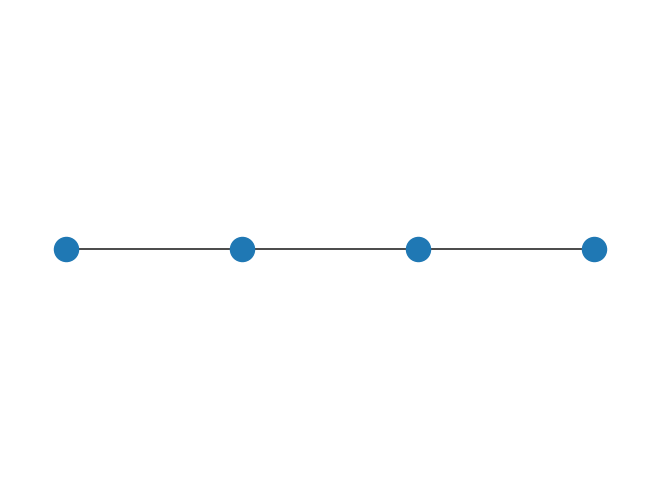

In [27]:
# Instantiate Line_Lattice for Hamiltonian generation:

heisenberg_line_lattice = LineLattice(num_nodes=4, boundary_condition=BoundaryCondition.OPEN)
heisenberg_model = HeisenbergModel(heisenberg_line_lattice, (1.0, 1.0, 1.0), (0.0, 0.0, 1.0))
heisenberg_line_lattice.draw()

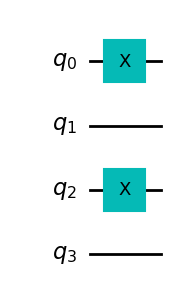

In [28]:
# Obtain Second Quantized operator of Heisenberg Model Hamiltonian:

hb_Ham = heisenberg_model.second_q_op()

# Invoke Linear Mapper/Transformation to bring Hamiltonian into Qubit Space:

log_map = LogarithmicMapper()

qubit_hb_Ham = log_map.map(hb_Ham.simplify())

# Construct appropriate ansatz for Variational Time Evolution:

hb_initial_state = QuantumCircuit(qubit_hb_Ham.num_qubits)
hb_initial_state.x(range(0, qubit_hb_Ham.num_qubits, 2))

hb_initial_state.draw('mpl') # Known as the Néel state of a Lattice-based Hamiltonian

The cell above produces the initial ground state from which the system will evolve. In the case of the Heisenberg Hamiltonian, the initial state is called the Néel state [3]. Other configurations than the one presented are possible; view the appended reference for further information on Néel states.

In [29]:
# Select an appropriate order, accuracy, evolution time, time step size, and Trotter number for the Product Formula:

'''These are the general control parameters for the Heisenberg Hamiltonian. Refer to these (and change) these variables to experiment with various product formulas'''

hb_final_time = 25 # Termination time of real time evolution.
hb_time_step = 0.1 # Time step increment for sampling purposes. Does not affect the Product Formula construction.
hb_epsilon = 1.6 * 10**-3 # Select a desired chemical accuracy for simulation purposes.
hb_reps = 10 # Number of repetitions, as per [REFERENCE], that will divide the time-step and circuit repetition count.

hb_evo_time_range = np.arange(0, hb_final_time, hb_time_step) # Define a time evolution range that will scale to the plotted Hamiltonian evolution.

**Run the cell below to execute the qDRIFT algorithm! Drawing the resulting circuit is optional. Uncomment the command to visualize the circuit.**

In [30]:
# Invoke the qDRIFT Protocol:

qDRIFT_result_heisenberg = qDRIFT_protocol(qubit_hb_Ham, hb_initial_state, hb_evo_time_range, hb_epsilon, hb_reps)

'''Warning: Given the nature of qDRIFT, accurate approximation leads to esxponentially large gate complexity! Be careful when drawing!'''

#qDRIFT_result_heisenberg[0].draw('mpl', filename='./Circuit Drawings/qDRIFT_Circuit_' + str(hb_reps) + 'r_' + str(heisenberg_line_lattice.num_nodes) + 'N_heisenberg') # Draw the resulting circuit.

'Warning: Given the nature of qDRIFT, accurate approximation leads to esxponentially large gate complexity! Be careful when drawing!'

In [31]:
# Obtain a list of states that are meaningful to plot (i.e., have some probability of being measured):

hb_states = identify_states(qDRIFT_result_heisenberg[2], qubit_hb_Ham, hb_evo_time_range)

print("The list of meaningful states is: " + str(hb_states))

# Obtain a list of coefficients that correspond to meaningful states: 

hb_coefficients_re_approx = np.zeros(shape=(2**(qubit_hb_Ham.num_qubits), len(hb_evo_time_range)))
hb_coefficients_im_approx = np.zeros(shape=(2**(qubit_hb_Ham.num_qubits), len(hb_evo_time_range)))

for i in range(2**qubit_hb_Ham.num_qubits):

    for j in range(len(hb_evo_time_range)):

        real = qDRIFT_result_heisenberg[2][i][j][0]
        imag = qDRIFT_result_heisenberg[2][i][j][1]

        hb_coefficients_re_approx[i][j] = real 
        hb_coefficients_im_approx[i][j] = imag

The list of meaningful states is: [0, 3, 5, 6]


#### Heisenberg Hamiltonian Expectation Value over Time Evolution:

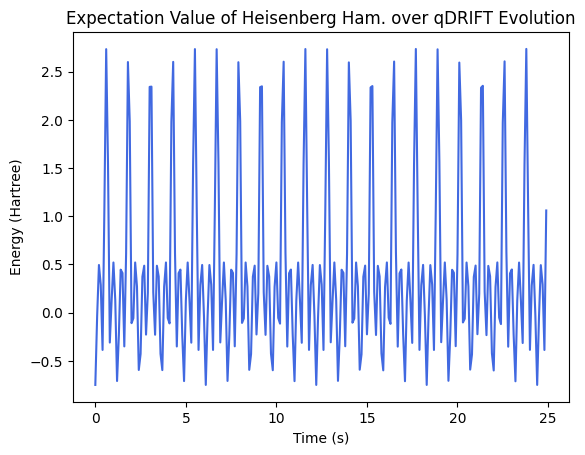

In [32]:
# Graph the energy variation over the specified time interval:

plt.plot(hb_evo_time_range, qDRIFT_result_heisenberg[1], color="royalblue")
plt.xlabel("Time (s)")
plt.ylabel("Energy (Hartree)")
plt.title("Expectation Value of Heisenberg Ham. over qDRIFT Evolution")
plt.savefig('./Plots/qDRIFT/Expectation Values/heisenberg_'+ str(hb_evo_time_range[-1]) + 's_' + str(hb_reps) + 'r_' + str(heisenberg_line_lattice.num_nodes) + 'N.png')

#### Heisenberg State Coefficients:

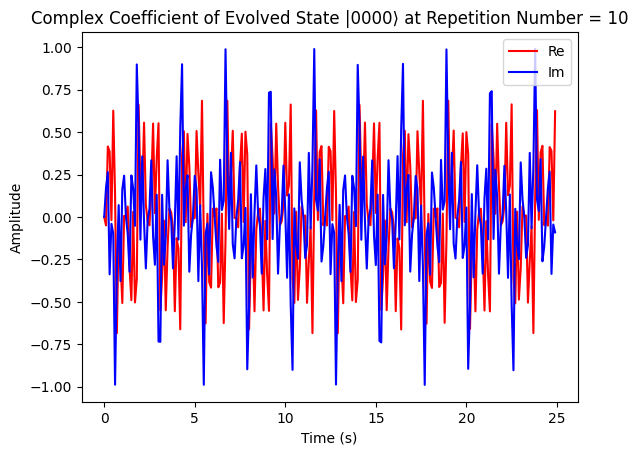

In [34]:
# Plot the evolved state coefficients:

plt.plot(hb_evo_time_range, hb_coefficients_re_approx[hb_states[0]], color = 'r', label = "Re")
plt.plot(hb_evo_time_range, hb_coefficients_im_approx[hb_states[0]], color = 'b', label = "Im")
plt.title('Complex Coefficient of Evolved State |' + format(hb_states[0], '0' + str(qubit_hb_Ham.num_qubits) + 'b') + '⟩ at Repetition Number = ' + str(hb_reps))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc="best")
plt.savefig('./Plots/qDRIFT/States/Coefficient_heisenberg_'+ format(hb_states[0], '0' + str(qubit_hb_Ham.num_qubits) + 'b') + '_' + str(hb_reps) + 'r_' + str(heisenberg_line_lattice.num_nodes) + 'N.png' )


The above diagram showcases the real and imaginary components of the associated state selected. Try to experiment with different samplings of the qDRIFT probability distribution by running the algorithm again!

#### Necessary Gate Count for Constant Accuracy:


In [35]:
# Calculate the necessary gate count for constant accuracy:

hb_N = np.ceil((2 * qDRIFT_result_heisenberg[3][0]**2 * hb_evo_time_range[-1]**2) / (hb_epsilon))

print("The necessary total gate count for constant accuracy is: " + str(hb_N))

The necessary total gate count for constant accuracy is: 8222107613.0


#### Trotter Error Bound:

In [36]:
# Calculate the upper bounded Trotter error of the qDRIFT configuration:

'''Warning: Using low repetition counts for the qDRIFT protocol will result in an inexpressibly high Trotter Error (i.e., O(inf)). Be aware!'''

hb_error = (2 * qDRIFT_result_heisenberg[3][0]**2 * hb_final_time**2) / hb_reps

print("The associated upper bound Trotter Error of this qDRIFT configuration is: O(" + str(hb_error) + ")")

The associated upper bound Trotter Error of this qDRIFT configuration is: O(1326125.0)


### Relationship Plots:

#### Trotter Error vs. Repetitions:

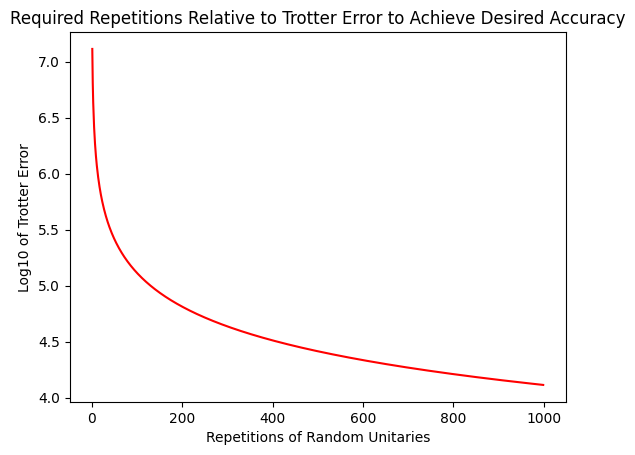

In [483]:
# Plot the relationship between Repetitions and Trotter Error:

hb_rep_range = np.arange(1, hb_reps, 1) # Range to plot Product Formula order
hb_rep_num_range = list() # List for Trotter Number required per order and qubits.

for j in range(len(hb_rep_range)):
    hb_rep_num_range.append((2 * qDRIFT_result_heisenberg[3][0]**2 * hb_final_time**2) / hb_rep_range[j])

plt.plot(hb_rep_range, np.log10(hb_rep_num_range), color="red")
plt.xlabel("Repetitions of Random Unitaries")
plt.ylabel("Log10 of Trotter Error")
plt.title("Required Repetitions Relative to Trotter Error to Achieve Desired Accuracy")
plt.savefig('./Plots/qDRIFT/Relationship Diagrams/Error_vs_Rep_heisenberg_' + str(hb_reps) + 'r_' + str(heisenberg_line_lattice.num_nodes) + 'N.png' )

#### Trotter Error vs. Time:

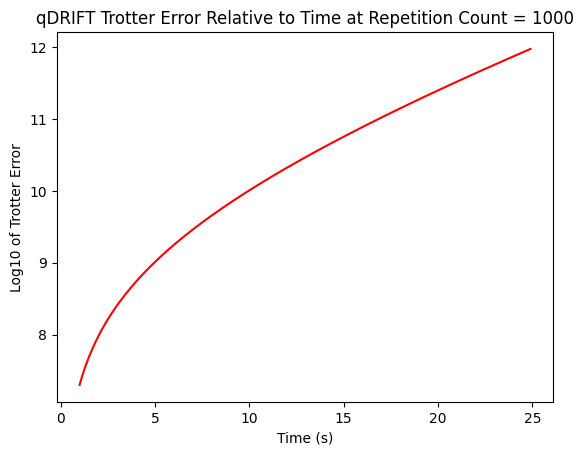

In [484]:
# Plot the relationship between time and Trotter Error given current repetition count:

hb_time_range = np.arange(1, hb_final_time, 0.1) # Range to plot Product Formula order
hb_error_times = list() # List for Trotter Number required per order and qubits.

for j in range(len(hb_time_range)):
    hb_error_times.append((len(qubit_hb_Ham)**2 * (max(qDRIFT_result_heisenberg[3][2]))**2 * (hb_time_range[j])**2 * np.exp((max(qDRIFT_result_heisenberg[3][2]) * hb_time_range[j] * len(qubit_hb_Ham))/hb_reps)) / 2 * hb_reps)

plt.plot(hb_time_range, np.log10(hb_error_times), color="red")
plt.xlabel("Time (s)")
plt.ylabel("Log10 of Trotter Error")
plt.title("qDRIFT Trotter Error Relative to Time at Repetition Count = " + str(hb_reps))
plt.savefig('./Plots/qDRIFT/Relationship Diagrams/Error_vs_Time_heisenberg_' + str(hb_reps) + 'r_' + str(heisenberg_line_lattice.num_nodes) + 'N.png' )

### Via Standard Methods:

**The cell below must be executed prior to plotting the comparison between the approximation and ideal time evolutions found below. This must be done for each modification to the approximation model.**

In [37]:
# Obtain a list of states that are meaningful to plot (i.e., have some probability of being measured):

exact_attri = state_generation(qubit_hb_Ham, hb_evo_time_range, hb_initial_state)

hb_states = identify_states(exact_attri[0], qubit_hb_Ham, hb_evo_time_range)

print("The list of ideal meaningful states is: " + str(hb_states))

# Obtain a list of coefficients that correspond to meaningful states: 

hb_coefficients_re_ex = np.zeros(shape=(2**(qubit_hb_Ham.num_qubits), len(hb_evo_time_range)))
hb_coefficients_im_ex = np.zeros(shape=(2**(qubit_hb_Ham.num_qubits), len(hb_evo_time_range)))

for i in range(2**qubit_hb_Ham.num_qubits):

    for j in range(len(hb_evo_time_range)):

        real = exact_attri[0][i][j][0]
        imag = exact_attri[0][i][j][1]

        hb_coefficients_re_ex[i][j] = real
        hb_coefficients_im_ex[i][j] = imag
        

The list of ideal meaningful states is: [3, 5, 6, 9, 10, 12]


#### Ideal Expectation Value:

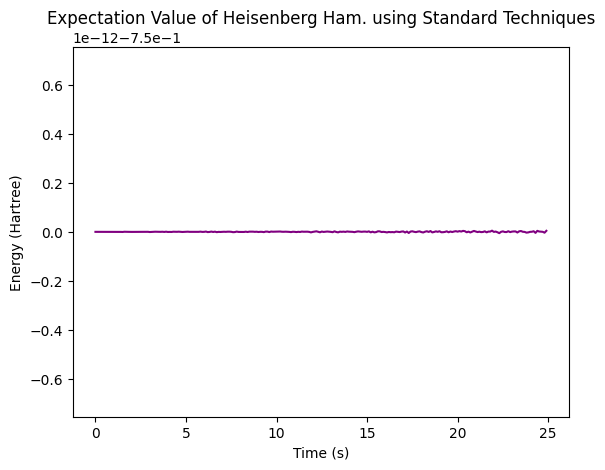

In [38]:
# Plot the expectation value of the exact time evolution:

plt.plot(hb_evo_time_range, exact_attri[1], color='purple')
plt.xlabel("Time (s)")
plt.ylabel("Energy (Hartree)")
plt.title("Expectation Value of Heisenberg Ham. using Standard Techniques")
plt.savefig("./Plots/qDRIFT/Expectation Values/Expectation_Value_Standard_heisenberg_" + str(heisenberg_line_lattice.num_nodes) + "N.png")

#### Ideal State Coefficient Evolution:

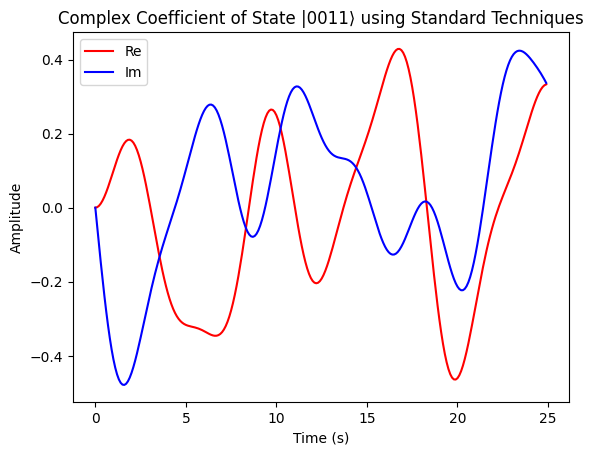

In [39]:
# Plot the Real and Imaginary components of the two resultant states in the evolved statevector:

plt.plot(hb_evo_time_range, hb_coefficients_re_ex[hb_states[0]], color='r', label= "Re")
plt.plot(hb_evo_time_range, hb_coefficients_im_ex[hb_states[0]], color='b', label= "Im")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc="best")
plt.title("Complex Coefficient of State |" + format(hb_states[0], '0' + str(qubit_hb_Ham.num_qubits) + 'b') + "⟩ using Standard Techniques")
plt.savefig("./Plots/qDRIFT/States/Complex_Coefficients_of_State_" + format(hb_states[0], '0' + str(qubit_hb_Ham.num_qubits) + 'b') + "_Standard_" + str(hb_final_time) + "s_" + str(hb_reps) + "r_" + str(heisenberg_line_lattice.num_nodes) + "N_heisenberg.png")

#### Comparison between Approximate and Ideal Evolutions:

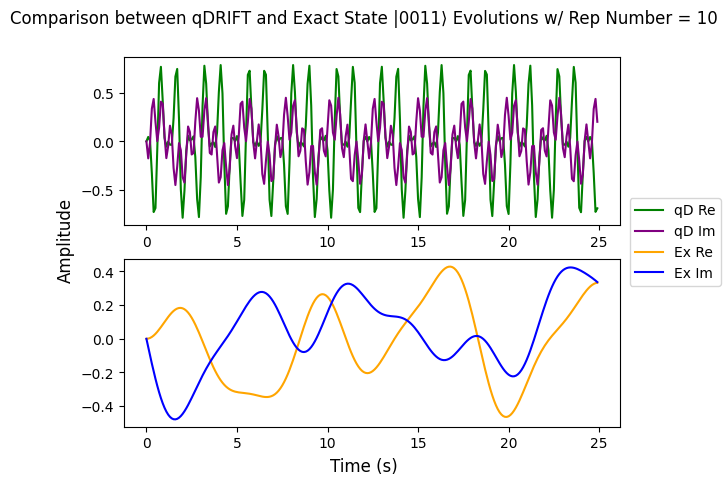

In [40]:
fig, axs = plt.subplots(2)
fig.suptitle("Comparison between qDRIFT and Exact State |" + format(hb_states[0], '0' + str(qubit_hb_Ham.num_qubits) + 'b') + "⟩ Evolutions w/ Rep Number = " + str(hb_reps))
axs[0].plot(hb_evo_time_range, hb_coefficients_re_approx[hb_states[0]], color = 'g', label = "qD Re")
axs[0].plot(hb_evo_time_range, hb_coefficients_im_approx[hb_states[0]], color = 'purple', label = "qD Im")
axs[1].plot(hb_evo_time_range, hb_coefficients_re_ex[hb_states[0]], color='orange', label= "Ex Re")
axs[1].plot(hb_evo_time_range, hb_coefficients_im_ex[hb_states[0]], color='b', label= "Ex Im")
fig.supxlabel("Time (s)")
fig.supylabel("Amplitude")
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lin, []) for lin in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.865,0.41))
plt.savefig("./Plots/qDRIFT/States/Coefficient_Comparison_of_State_" + format(hb_states[0], '0' + str(qubit_hb_Ham.num_qubits) + 'b') + "_" + str(hb_final_time) + "s_" + str(hb_reps) + "r_" + str(heisenberg_line_lattice.num_nodes) + "N_heisenberg.png")

In [41]:
# Calculate the Euclidean Distance between the two state coefficient plots:

for k in range(len(hb_states)):
    hb_re_distance = distance.euclidean(hb_coefficients_re_approx[hb_states[k]], hb_coefficients_re_ex[hb_states[k]])
    hb_im_distance = distance.euclidean(hb_coefficients_im_approx[hb_states[k]], hb_coefficients_im_ex[hb_states[k]])

    print("The Real Euclidean distance/error of state |" + format(hb_states[k], '0' + str(qubit_hb_Ham.num_qubits) + 'b') + "⟩ is: " + str(hb_re_distance))
    print("The Imaginary Euclidean distance/error of state |" + format(hb_states[k], '0' + str(qubit_hb_Ham.num_qubits) + 'b') + "⟩ is: " + str(hb_im_distance))

The Real Euclidean distance/error of state |0011⟩ is: 7.908869986908448
The Imaginary Euclidean distance/error of state |0011⟩ is: 5.353568677598723
The Real Euclidean distance/error of state |0101⟩ is: 9.05905213038101
The Imaginary Euclidean distance/error of state |0101⟩ is: 7.5075161594869915
The Real Euclidean distance/error of state |0110⟩ is: 5.1516606241494625
The Imaginary Euclidean distance/error of state |0110⟩ is: 7.599088210324838
The Real Euclidean distance/error of state |1001⟩ is: 3.179319284887622
The Imaginary Euclidean distance/error of state |1001⟩ is: 3.2501372379332003
The Real Euclidean distance/error of state |1010⟩ is: 6.517547210204316
The Imaginary Euclidean distance/error of state |1010⟩ is: 6.142171427092852
The Real Euclidean distance/error of state |1100⟩ is: 3.3278074137234177
The Imaginary Euclidean distance/error of state |1100⟩ is: 3.7311484737457494


### Ising Model (Lattice-based):

The Transverse-field Ising Hamiltonian, like the Heisenberg Hamiltonian, represents a ferromagnetic lattice system that is occupied by spin ½ particles that experience interactions between nearest-neighbors and external magnetic fields:

$$ H = - \sum_{\langle i, j \rangle}{J_{ij} Z_i Z_j} \ - \sum_{i}{g_i X_i}$$

This model features interactions between lattice sites at the ${i}$-th and ${j}$-th locations, and the external magnetic field acts on the ${i}$-th site. The variable ${J_{ij}}$ is the coupling constant between ${i}$-th and ${j}$-th site, while the coupling parameters ${g_i}$ determine the relative strength between the nearest neighbor interactions and external transverse field [21].

The second quantized form of the Hamiltonian is akin to the Heisenberg Hamiltonian equivalent; likewise, the following implementation also employs the logarithmic transformation/mapper to bring the bosonic system to the qubit space. 

We will now implement the qDRIFT protocol using Ising Hamiltonians and compare results to the ideal time evolution.

In [42]:
# Instantiate Line_Lattice for Hamiltonian generation:

line_lattice = LineLattice(num_nodes=4, boundary_condition=BoundaryCondition.OPEN)
ising_model = IsingModel(
    line_lattice.uniform_parameters(
        uniform_interaction = -1.0,
        uniform_onsite_potential = 1.0,
    ),
)

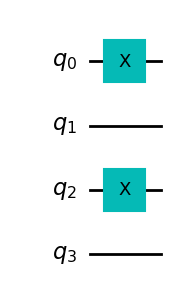

In [43]:
# Obtain Second Quantized operator of Ising Model Hamiltonian:

i_Ham = ising_model.second_q_op()

# Invoke Linear Mapper/Transformation to bring Hamiltonian into Qubit Space:

log_map = LogarithmicMapper()

qubit_i_Ham = log_map.map(i_Ham.simplify())

# Construct appropriate ansatz for Real Time Evolution:

i_initial_state = QuantumCircuit(qubit_i_Ham.num_qubits)
i_initial_state.x(range(0, qubit_i_Ham.num_qubits, 2))

i_initial_state.draw('mpl') # Known as the Néel state of a Lattice-based Hamiltonian

In [44]:
# Select an appropriate order, accuracy, evolution time, time step size, and Trotter number for the Product Formula:

'''These are the general control parameters for the Ising Hamiltonian. Refer to these (and change) these variables to experiment with various product formulas'''

i_final_time = 25 # Termination time of real time evolution.
i_time_step = 0.1 # Time step increment for sampling purposes. Does not affect the Product Formula construction.
i_epsilon = 1.6 * 10**-3 # Select a desired chemical accuracy for simulation purposes.
i_reps = 10 # Number of repetitions, as per [REFERENCE], that will divide the time-step and circuit repetition count.

i_evo_time_range = np.arange(0, i_final_time, i_time_step) # Define a time evolution range that will scale to the plotted Hamiltonian evolution.

**Run the cell below to execute the qDRIFT algorithm! Drawing the resulting circuit is optional. Uncomment the command to visualize the circuit.**

In [45]:
# Invoke the qDRIFT Protocol:

qDRIFT_result_ising = qDRIFT_protocol(qubit_i_Ham, i_initial_state, i_evo_time_range, i_epsilon, i_reps)

'''Warning: Given the nature of qDRIFT, accurate approximation leads to esxponentially large gate complexity! Be careful when drawing!'''

#qDRIFT_result_ising[0].draw('mpl', filename='./Circuit Drawings/qDRIFT_Circuit_' + str(i_reps) + 'r_' + str(line_lattice.num_nodes) + 'N_ising') # Draw the resulting circuit.

'Warning: Given the nature of qDRIFT, accurate approximation leads to esxponentially large gate complexity! Be careful when drawing!'

In [46]:
# Obtain a list of states that are meaningful to plot (i.e., have some probability of being measured):

i_states = identify_states(qDRIFT_result_ising[2], qubit_i_Ham, i_evo_time_range)

print(i_states)

# Obtain a list of coefficients that correspond to meaningful states: 

i_coefficients_re_approx = np.zeros(shape=(2**(qubit_i_Ham.num_qubits), len(i_evo_time_range)))
i_coefficients_im_approx = np.zeros(shape=(2**(qubit_i_Ham.num_qubits), len(i_evo_time_range)))

for i in range(2**qubit_i_Ham.num_qubits):

    for j in range(len(i_evo_time_range)):

        real = qDRIFT_result_ising[2][i][j][0]
        imag = qDRIFT_result_ising[2][i][j][1]

        i_coefficients_re_approx[i][j] = real 
        i_coefficients_im_approx[i][j] = imag

[0, 1, 4, 5]


#### Ising Hamiltonian Expectation Value over Time Evolution:

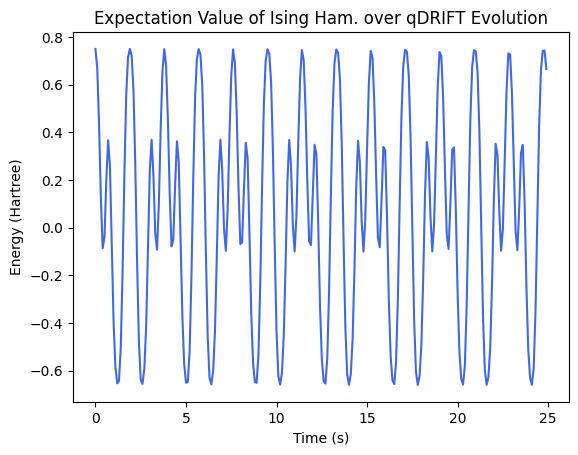

In [47]:
# Graph the energy variation over the specified time interval:

plt.plot(i_evo_time_range, qDRIFT_result_ising[1], color="royalblue")
plt.xlabel("Time (s)")
plt.ylabel("Energy (Hartree)")
plt.title("Expectation Value of Ising Ham. over qDRIFT Evolution")
plt.savefig('./Plots/qDRIFT/Expectation Values/ising_'+ str(i_evo_time_range[-1]) + 's_' + str(i_reps) + 'r_' + str(line_lattice.num_nodes) + 'N.png')

#### Ising State Coefficients:

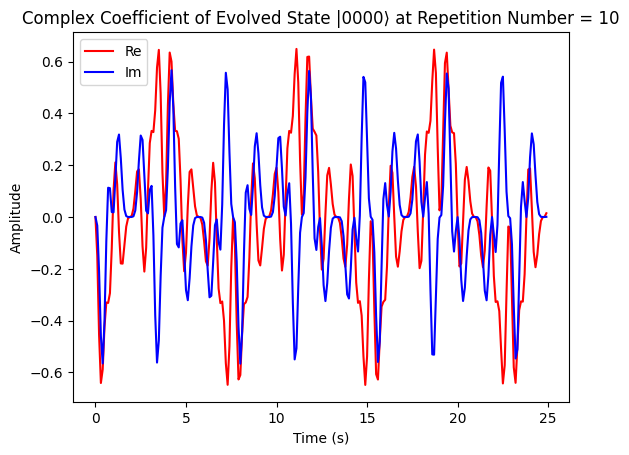

In [48]:
# Plot the evolved state coefficients:

plt.plot(i_evo_time_range, i_coefficients_re_approx[i_states[0]], color = 'r', label = "Re")
plt.plot(i_evo_time_range, i_coefficients_im_approx[i_states[0]], color = 'b', label = "Im")
plt.title('Complex Coefficient of Evolved State |' + format(i_states[0], '0' + str(qubit_i_Ham.num_qubits) + 'b') + '⟩ at Repetition Number = ' + str(i_reps))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc="best")
plt.savefig('./Plots/qDRIFT/States/Coefficient_ising_' + format(i_states[0], '0' + str(qubit_i_Ham.num_qubits) + 'b') + '_' + str(i_final_time) + 's_' + str(line_lattice.num_nodes) +  'N.png' )

#### Necessary Gate Count for Constant Accuracy:

In [49]:
# Calculate the necessary gate count for constant accuracy:

i_N = np.ceil((2 * qDRIFT_result_ising[3][0]**2 * i_evo_time_range[-1]**2) / (i_epsilon))

print("The necessary total gate count for constant accuracy is: " + str(i_N))

The necessary total gate count for constant accuracy is: 843988613.0


#### Trotter Error Bound:

In [50]:
# Calculate the upper bounded Trotter error of the qDRIFT configuration:

'''Warning: Using low repetition counts for the qDRIFT protocol will result in an inexpressibly high Trotter Error (i.e., O(inf)). Be aware!'''

i_error = (2 * qDRIFT_result_ising[3][0]**2 * i_final_time**2) / i_reps

print("The associated upper bound Trotter Error of this qDRIFT configuration is: O(" + str(i_error) + ")")

The associated upper bound Trotter Error of this qDRIFT configuration is: O(136125.0)


### Relationship Plots:

#### Trotter Error vs. Repetitions:

/tmp/ipykernel_6322/2835549204.py:7: RuntimeWarning: overflow encountered in exp
  i_rep_num_range.append((len(qubit_i_Ham)**2 * (max(qDRIFT_result_ising[3][2]))**2 * (i_final_time)**2 * np.exp((max(qDRIFT_result_ising[3][2]) * i_final_time * len(qubit_i_Ham))/i_rep_range[j])) / 2 * i_rep_range[j])
/tmp/ipykernel_6322/2835549204.py:7: RuntimeWarning: overflow encountered in double_scalars
  i_rep_num_range.append((len(qubit_i_Ham)**2 * (max(qDRIFT_result_ising[3][2]))**2 * (i_final_time)**2 * np.exp((max(qDRIFT_result_ising[3][2]) * i_final_time * len(qubit_i_Ham))/i_rep_range[j])) / 2 * i_rep_range[j])


Text(0.5, 1.0, 'Required Repetitions Relative to Trotter Error to Achieve Desired Accuracy')

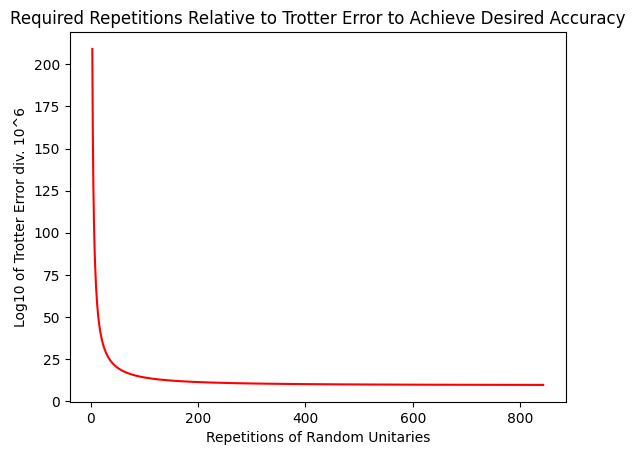

In [53]:
# Plot the relationship between Repetitions and Trotter Error:

i_rep_range = np.arange(1, i_N / 10**6, 1) # Range to plot Product Formula order
i_rep_num_range = list() # List for Trotter Number required per order and qubits.

for j in range(len(i_rep_range)):
    i_rep_num_range.append((len(qubit_i_Ham)**2 * (max(qDRIFT_result_ising[3][2]))**2 * (i_final_time)**2 * np.exp((max(qDRIFT_result_ising[3][2]) * i_final_time * len(qubit_i_Ham))/i_rep_range[j])) / 2 * i_rep_range[j])

plt.plot(i_rep_range, np.log10(i_rep_num_range), color="red")
plt.xlabel("Repetitions of Random Unitaries")
plt.ylabel("Log10 of Trotter Error div. 10^6")
plt.title("Required Repetitions Relative to Trotter Error to Achieve Desired Accuracy")

#### Trotter Error vs. Time:

Text(0.5, 1.0, 'qDRIFT Trotter Error Relative to Time at Repetition Count = 10')

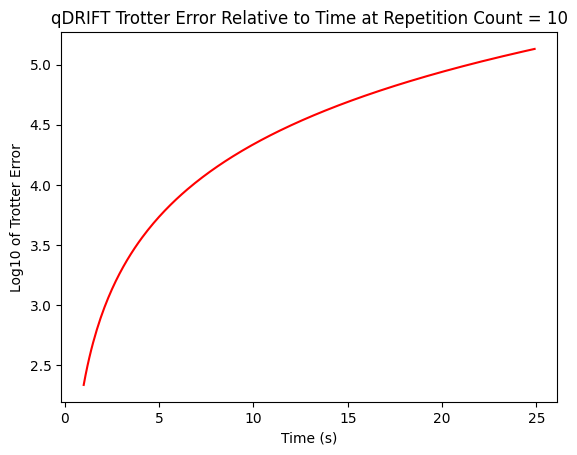

In [54]:
# Plot the relationship between time and Trotter Error given current repetition count:

i_time_range = np.arange(1, i_final_time, 0.1) # Range to plot Product Formula order
i_error_times = list() # List for Trotter Number required per order and qubits.

for j in range(len(i_time_range)):
    i_error_times.append((2 * qDRIFT_result_ising[3][0]**2 * i_time_range[j]**2) / i_reps)

plt.plot(i_time_range, np.log10(i_error_times), color="red")
plt.xlabel("Time (s)")
plt.ylabel("Log10 of Trotter Error")
plt.title("qDRIFT Trotter Error Relative to Time at Repetition Count = " + str(i_reps))

### Via Standard Methods:

**The cell below must be executed prior to plotting the comparison between the approximation and ideal time evolutions found below. This must be done for each modification to the approximation model.**

In [55]:
# Obtain a list of states that are meaningful to plot (i.e., have some probability of being measured):

exact_attri = state_generation(qubit_i_Ham, i_evo_time_range, i_initial_state)

i_states = identify_states(exact_attri[0], qubit_i_Ham, i_evo_time_range)

print(i_states)

# Obtain a list of coefficients that correspond to meaningful states: 

i_coefficients_re_ex = np.zeros(shape=(2**(qubit_i_Ham.num_qubits), len(i_evo_time_range)))
i_coefficients_im_ex = np.zeros(shape=(2**(qubit_i_Ham.num_qubits), len(i_evo_time_range)))

for i in range(2**qubit_i_Ham.num_qubits):

    for j in range(len(i_evo_time_range)):

        real = exact_attri[0][i][j][0]
        imag = exact_attri[0][i][j][1]

        i_coefficients_re_ex[i][j] = real
        i_coefficients_im_ex[i][j] = imag
        

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


#### Ideal Expectation Value:

/home/ssr/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


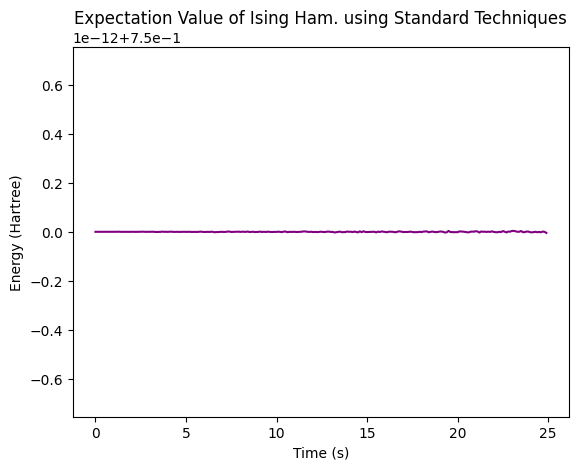

In [56]:
# Plot the expectation value of the exact time evolution:

plt.plot(i_evo_time_range, exact_attri[1], color='purple')
plt.xlabel("Time (s)")
plt.ylabel("Energy (Hartree)")
plt.title("Expectation Value of Ising Ham. using Standard Techniques")
plt.savefig("./Plots/qDRIFT/Expectation Values/Expectation_Value_Standard_ising_" + str(line_lattice.num_nodes) + "N.png")

#### Ideal State Coefficient Evolution:

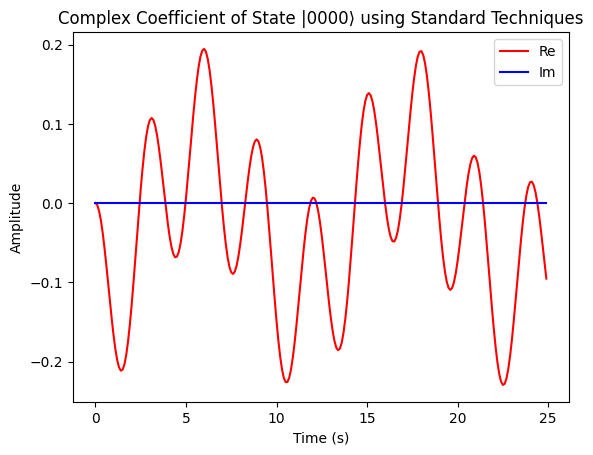

In [57]:
# Plot the Real and Imaginary components of the two resultant states in the evolved statevector:

plt.plot(i_evo_time_range, i_coefficients_re_ex[i_states[0]], color='r', label= "Re")
plt.plot(i_evo_time_range, i_coefficients_im_ex[i_states[0]], color='b', label= "Im")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc="best")
plt.title("Complex Coefficient of State |" + format(i_states[0], '0' + str(qubit_i_Ham.num_qubits) + 'b') + "⟩ using Standard Techniques")
plt.savefig("./Plots/qDRIFT/States/Complex_Coefficients_of_State_" + format(i_states[0], '0' + str(qubit_i_Ham.num_qubits) + 'b') + "_Standard_" + str(i_final_time) + "s_" + str(i_reps) + "r_" + str(line_lattice.num_nodes) + "N_ising.png")

### Comparison between approximate and ideal evolutions:

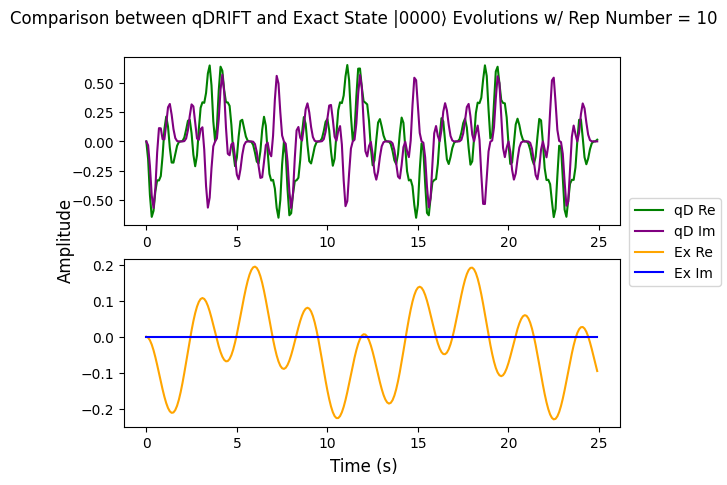

In [58]:
fig, axs = plt.subplots(2)
fig.suptitle("Comparison between qDRIFT and Exact State |" + format(i_states[0], '0' + str(qubit_i_Ham.num_qubits) + 'b') + "⟩ Evolutions w/ Rep Number = " + str(i_reps))
axs[0].plot(i_evo_time_range, i_coefficients_re_approx[i_states[0]], color = 'g', label = "qD Re")
axs[0].plot(i_evo_time_range, i_coefficients_im_approx[i_states[0]], color = 'purple', label = "qD Im")
axs[1].plot(i_evo_time_range, i_coefficients_re_ex[i_states[0]], color='orange', label= "Ex Re")
axs[1].plot(i_evo_time_range, i_coefficients_im_ex[i_states[0]], color='b', label= "Ex Im")
fig.supxlabel("Time (s)")
fig.supylabel("Amplitude")
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lin, []) for lin in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.865,0.41))
plt.savefig("./Plots/qDRIFT/States/Coefficient_Comparison_of_State_" + format(i_states[0], '0' + str(qubit_i_Ham.num_qubits) + 'b') + "_" + str(i_final_time) + "s_" + str(i_reps) + "r_" + str(line_lattice.num_nodes) + "N_ising.png")

In [59]:
# Calculate the Euclidean Distance between the two state coefficient plots:

for k in range(len(i_states)):
    i_re_distance = distance.euclidean(i_coefficients_re_approx[i_states[k]], i_coefficients_re_ex[i_states[k]])
    i_im_distance = distance.euclidean(i_coefficients_im_approx[i_states[k]], i_coefficients_im_ex[i_states[k]])

    print("The Real Euclidean distance/error of state |" + format(i_states[k], '0' + str(qubit_i_Ham.num_qubits) + 'b') + "⟩ is: " + str(i_re_distance))
    print("The Imaginary Euclidean distance/error of state |" + format(i_states[k], '0' + str(qubit_i_Ham.num_qubits) + 'b') + "⟩ is: " + str(i_im_distance))

The Real Euclidean distance/error of state |0000⟩ is: 4.85683795736734
The Imaginary Euclidean distance/error of state |0000⟩ is: 3.679160049223798
The Real Euclidean distance/error of state |0001⟩ is: 5.884407222564427
The Imaginary Euclidean distance/error of state |0001⟩ is: 7.862557006209835
The Real Euclidean distance/error of state |0010⟩ is: 2.212419354869221
The Imaginary Euclidean distance/error of state |0010⟩ is: 2.763424606471415
The Real Euclidean distance/error of state |0011⟩ is: 2.135823544083515
The Imaginary Euclidean distance/error of state |0011⟩ is: 1.6091067708666078
The Real Euclidean distance/error of state |0100⟩ is: 5.101628683071888
The Imaginary Euclidean distance/error of state |0100⟩ is: 3.7563737828667283
The Real Euclidean distance/error of state |0101⟩ is: 8.758575896448779
The Imaginary Euclidean distance/error of state |0101⟩ is: 9.337081459941574
The Real Euclidean distance/error of state |0110⟩ is: 2.786986789875673
The Imaginary Euclidean distance/

With all Hamiltonians accounted, we will provide a summary of the qDRIFT algorithm, its pros and cons, and a review of its performance.

### Discussion:

Via the presented examples, plots, circuits, and comparative diagrams, the qDRIFT protocol has demonstrated a stochastic approach to simulating quantum dynamics of a Hamiltonian system. Although demanding high gate counts for idealized time evolutions, the qDRIFT protocol exceeds the performance, in both gate count and Trotter error, of lower-order product formulas at low time evolutions [4]. Moreover, the usage of qDRIFT can potentially aid in the reduction of in time-dependent evolution settings, as commonly found within physical settings [2]. Each of these benefits are achieved without invoking ancillary qubits during the algorithm’s procedure.


In contrast with higher-order and first-order product formulas, the qDRIFT protocol possesses a greater gate complexity at higher simulation times, typically within the range of t = 107 to 108 [5]. Such an attribute renders qDRIFT unviable for extended time evolutions, as the necessary circuit for simulation would quickly become impractical to implement. 
In summary, the associated pros and cons of the qDRIFT protocol are:

-	Pros: 
    -	Trotter error and gate complexity is not dependent upon the number of summands within Hamiltonian [4].
    -	Like product formulas, qDRIFT does not use any ancillary qubits to perform its operation [3].
    -	Surpasses performance in error and gate complexity at short time intervals as compared to other product formulas [5].
-	Cons:
    -	At large time evolutions, the gate complexity and, in turn, error of a qDRIFT protocol becomes worse than either first-order or higher-order product formulas [4].
    -	A large repetition count is necessary to obtain near-ideal time evolution curves.
    -	Low repetition counts will generate highly erroneous evolutions [4].

### Citations:

1.	Qiskit – Electronic Structure: https://qiskit.org/ecosystem /nature/tutorials/01_electronic_structure.html 
2.	Campbell, E. A random compiler for fast Hamiltonian simulation. Phys. Rev. Lett. 123, 070503 (2019), 1. 
3.	Campbell, E. A random compiler for fast Hamiltonian simulation. Phys. Rev. Lett. 123, 070503 (2019), 2.
4.	Campbell, E. A random compiler for fast Hamiltonian simulation. Phys. Rev. Lett. 123, 070503 (2019), 3.
5.	Campbell, E. A random compiler for fast Hamiltonian simulation. Phys. Rev. Lett. 123, 070503 (2019), 4.
6.	Quantum Condensed Matter Field Theory (Chapter 2) – University of Cambridge Lecture Notes: https://www.tcm.phy.cam.ac.uk/~bds10/tp3/secqu.pdf 
7.	Childs, A. M., Su, Y., Tran, M. C., Wiebe, N., Zhu, S. A Theory of Trotter Error. Phys. Rev. X. 11, 011020 (2021), 12.
